In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import sys
import seaborn as sns
import matplotlib.ticker as mtick


# Known Alt Haps

In [23]:
kmers_ground_truth = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/data/known_kmers.txt',  
                                   delimiter='\t', header=None, names=['name', 'pos'], usecols=[1,2])#, nrows=100000, skiprows=600000)#len(regions_ground_truth))
regions_ground_truth = pd.read_table(#'/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/localize/ground_truth/localized_006.txt',
    '/home/groups/dpwall/briannac/alt_haplotypes/results/approximate_regions/localized_ground_truth.tsv',
    #'/home/groups/dpwall/briannac/alt_haplotypes/results/approximate_regions/localized_ground_truth.tsv',
                                   names = ['chrom_true', 'loci_true', 'median_of_nonzeros', 'prevalence',
                                            'chrom_pred_0','start_pred_0','end_pred_0',
                                            'chrom_pred_0.05','start_pred_0.05','end_pred_0.05',
                                            'chrom_pred_0.1','start_pred_0.1','end_pred_0.1',
                                            'chrom_pred_0.15','start_pred_0.15','end_pred_0.15',
                                            'chrom_pred_0.2', 'start_pred_0.2', 'end_pred_0.2', 
                                            'chrom_pred_0.25','start_pred_0.25','end_pred_0.25',
                                            'chrom_pred_0.5',  'start_pred_0.5',  'end_pred_0.5',
                                            'chrom_pred_1',  'start_pred_1',  'end_pred_1'], delimiter='\t',
                                   comment='#', header=None, nrows=len(kmers_ground_truth))
regions_ground_truth = regions_ground_truth.replace(2323, 23).replace(2424,24)
regions_ground_truth['start_true'] = [int(r.split(':')[-1].split('-')[0]) for r in kmers_ground_truth['pos']]
regions_ground_truth['end_true'] = [int(r.split(':')[-1].split('-')[1]) for r in kmers_ground_truth['pos']]
regions_ground_truth['hap_name'] = kmers_ground_truth['name']

In [28]:
np.log2(.99)

-0.01005033585350145



 0
unlocalized:  0.01694864476207077
localized:  0.9830513552379292
correct:  0.8171490979606066
correct_chrom out of inccorect:  0.603243917654398
median distance from true: 530267.0
incorrect:  0.16590225727732263
accuracy:  0.8312374461483052
med length: 342288.0


 0.05
unlocalized:  0.02682423304863169
localized:  0.9731757669513683
correct:  0.8577081880773924
correct_chrom out of inccorect:  0.5018397962071893
median distance from true: 908290.0
incorrect:  0.11546757887397595
accuracy:  0.8813497183189251
med length: 584587.0


 0.1
unlocalized:  0.035855521178316196
localized:  0.9641444788216839
correct:  0.8715819461390971
correct_chrom out of inccorect:  0.4597775554640146
median distance from true: 1307217.0
incorrect:  0.09256253268258671
accuracy:  0.903995163882792
med length: 875540.0


 0.15
unlocalized:  0.044086085933414676
localized:  0.9559139140665853
correct:  0.8790798762419383
correct_chrom out of inccorect:  0.4356456701286732
median distance from true: 179

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in long_scalars
/home/users/briannac/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/users/briannac/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in long_scalars


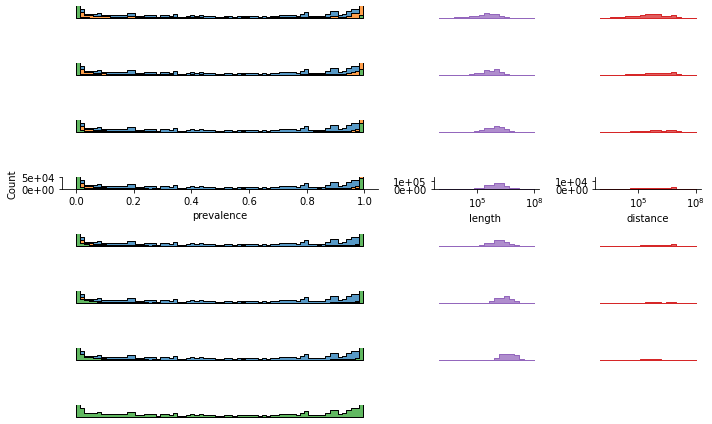

In [24]:
fig, ax = plt.subplots(nrows=8, ncols=3,figsize=(10,6),gridspec_kw={'width_ratios': [3, 1,1]})
for i, std_float in enumerate([0, .05, .1, .15, .2, .25, .5, 1]):
    std = str(std_float)
    print('\n\n', std)
    df = regions_ground_truth.copy()
    df = df [['hap_name', 'chrom_true', 'start_true', 'end_true', 'prevalence', 'chrom_pred_%s' % std, 'start_pred_%s' % std, 'end_pred_%s' % std]]
    df.columns = ['hap_name', 'chrom_true', 'start_true', 'end_true', 'prevalence', 'chrom_pred', 'start_pred', 'end_pred']
    

    

    unlocalized = df[np.isnan(df['chrom_pred'])].copy()
    unlocalized['status'] = 'unlocalized'
    localized = df[~np.isnan(df['chrom_pred'])].copy()

    correct = localized[(localized.chrom_true==localized['chrom_pred']) & 
          (localized['end_pred']>=localized.start_true) & (localized['start_pred']<=localized.end_true)].copy()
    correct['status'] = 'correct'
    incorrect = localized[~((localized.chrom_true==localized['chrom_pred']) & 
                          (localized['end_pred']>=localized.start_true) & 
                          (localized['start_pred']<=localized.end_true))].copy()
    incorrect['status'] = 'incorrect'

    new_df = pd.concat([correct, incorrect, unlocalized])
    new_df['length'] = new_df['end_pred']-new_df['start_pred']
    g = sns.histplot(new_df, x='prevalence', hue='status',  element='step', multiple='stack', hue_order=['correct', 'incorrect', 'unlocalized'], ax=ax[0], legend=False)
    ax[i,0].set_ylim(0,50000)
    ax[i,0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

    # Compute some metrics on subsection of dataframe.
    new_df = new_df[(new_df.prevalence>.2) & (new_df.prevalence<.8)]
    
    # Histograms of lengths for sensitivity
    sns.histplot(data=new_df[new_df.status=='correct'], x='length', element='step', bins=np.linspace(3,8,20), log_scale=True, ax=ax[i,1], color=sns.color_palette()[4], legend=False)
    ax[i,1].set_ylim(0,150000)
    ax[i,1].set_xlabel('length ')
    ax[i,1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

    
    
    # Distance from true value for incorrect
    right_chrom_wrong_loci = new_df[(~np.isnan(new_df.chrom_pred)) & (new_df.chrom_true==new_df['chrom_pred'])]
    new_df['distance'] = [2e20 if chrom_pred!=chrom_true else max(d1, d2) for d1, d2, chrom_pred, chrom_true in zip(new_df['start_true']-new_df['end_pred'], 
                                                      new_df['start_pred']-new_df['end_true'], new_df['chrom_pred'], new_df['chrom_true'])]
    sns.histplot(data=new_df[new_df.status=='incorrect'], x='distance', element='step', bins=np.linspace(3,8,20), log_scale=True, color=sns.color_palette()[3], ax=ax[i,2], legend=False)
    ax[i,2].set_ylim(0,15000)
    ax[i,2].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    
    
    for a in [0,1,2]:
        ax[i,a].spines["right"].set_visible(False)
        ax[i,a].spines["top"].set_visible(False)
        if a>0: ax[i,a].set_ylabel('')
    
    if i!=3:
        for a in [0,1,2]:
            ax[i,a].set_ylabel('')
            ax[i,a].set_xlabel('')
            ax[i,a].spines["bottom"].set_visible(False)
            ax[i,a].spines["left"].set_visible(False)
            ax[i,a].set_xticks([])
            ax[i,a].set_yticks([])
    
            

        
        
  

    print('unlocalized: ', np.mean(new_df.status=='unlocalized'))
    print('localized: ', np.mean(new_df.status!='unlocalized'))

    print('correct: ', np.mean(new_df.status=='correct'))
    print('correct_chrom out of inccorect: ', (np.sum((new_df.status=='incorrect') & (new_df.chrom_pred==new_df.chrom_true)))/np.sum(new_df.status=='incorrect'))
    print('median distance from true:', np.median(new_df[(new_df.chrom_pred==new_df.chrom_true) & (new_df.status=='incorrect')]['distance']))
    print('incorrect: ', np.mean(new_df.status=='incorrect'))
    print('accuracy: ', np.sum(new_df.status=='correct')/np.sum(new_df.status!='unlocalized'))
    print('med length:', np.median(new_df[new_df.status=='correct']['end_pred']-new_df[new_df.status=='correct']['start_pred']))
plt.tight_layout()
#plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/known_alt_haps_stats.svg', transparent=True, bbox_inches='tight',pad_inches = 0)
plt.show()

In [15]:
new_df

,hap_name,chrom_true,start_true,end_true,prevalence,chrom_pred,start_pred,end_pred,status,length
13,chr15_KI270849v1_alt,15.0,44676664,44913053,0.059,15.0,44803704.0,44838170.0,correct,34466.0
14,chr15_KI270849v1_alt,15.0,44676664,44913053,0.066,15.0,44803704.0,44838170.0,correct,34466.0
16,chr15_KI270849v1_alt,15.0,44676664,44913053,0.074,15.0,44803704.0,44838170.0,correct,34466.0
17,chr15_KI270849v1_alt,15.0,44676664,44913053,0.080,15.0,44905096.0,44905839.0,correct,743.0
53,chr15_KI270849v1_alt,15.0,44676664,44913053,0.132,15.0,44148561.0,44802939.0,correct,654378.0
...,...,...,...,...,...,...,...,...,...,...
95087,chr18_KI270864v1_alt,18.0,43667277,43773892,0.001,NaN,NaN,NaN,unlocalized,NaN
95088,chr18_KI270864v1_alt,18.0,43667277,43773892,0.001,NaN,NaN,NaN,unlocalized,NaN
95089,chr18_KI270864v1_alt,18.0,43667277,43773892,0.001,NaN,NaN,NaN,unlocalized,NaN
95090,chr18_KI270864v1_alt,18.0,43667277,43773892,0.001,NaN,NaN,NaN,unlocalized,NaN




 0.1
unlocalized:  0.035855521178316196
localized:  0.9641444788216839
correct:  0.8715819461390971
correct_chrom out of inccorect:  0.4597775554640146
median distance from true: 1307217.0
incorrect:  0.09256253268258671
accuracy:  0.903995163882792
med length: 875540.0


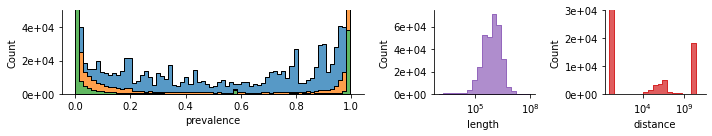

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(10,2),gridspec_kw={'width_ratios': [3, 1,1]})
for i, std_float in enumerate([.1]):
    std = str(std_float)
    print('\n\n', std)
    df = regions_ground_truth.copy()
    df = df [['hap_name', 'chrom_true', 'start_true', 'end_true', 'prevalence', 'chrom_pred_%s' % std, 'start_pred_%s' % std, 'end_pred_%s' % std]]
    df.columns = ['hap_name', 'chrom_true', 'start_true', 'end_true', 'prevalence', 'chrom_pred', 'start_pred', 'end_pred']
    
    unlocalized = df[np.isnan(df['chrom_pred'])].copy()
    unlocalized['status'] = 'unlocalized'
    localized = df[~np.isnan(df['chrom_pred'])].copy()

    correct = localized[(localized.chrom_true==localized['chrom_pred']) & 
          (localized['end_pred']>=localized.start_true) & (localized['start_pred']<=localized.end_true)].copy()
    correct['status'] = 'correct'
    incorrect = localized[~((localized.chrom_true==localized['chrom_pred']) & 
                          (localized['end_pred']>=localized.start_true) & 
                          (localized['start_pred']<=localized.end_true))].copy()
    incorrect['status'] = 'incorrect'

    new_df = pd.concat([correct, incorrect, unlocalized])
    new_df['length'] = new_df['end_pred']-new_df['start_pred']
    g = sns.histplot(new_df, x='prevalence', hue='status',  element='step', multiple='stack', hue_order=['correct', 'incorrect', 'unlocalized'], ax=ax[0], legend=False)
    ax[0].set_ylim(0,50000)
    ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

    # Compute some metrics on subsection of dataframe.
    new_df = new_df[(new_df.prevalence>.2) & (new_df.prevalence<.8)]
    
    # Histograms of lengths for sensitivity
    sns.histplot(data=new_df[new_df.status=='correct'], x='length', element='step', bins=np.linspace(3,8,20), log_scale=True, ax=ax[1], color=sns.color_palette()[4], legend=False)
    #ax[1].set_ylim(0,150000)
    ax[1].set_xlabel('length ')
    ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

    
    # Distance from true value for incorrect
    right_chrom_wrong_loci = new_df[(~np.isnan(new_df.chrom_pred)) & (new_df.chrom_true==new_df['chrom_pred'])]
    new_df['distance'] = [2e10 if chrom_pred!=chrom_true else max(d1, d2,1) for d1, d2, chrom_pred, chrom_true in zip(new_df['start_true']-new_df['end_pred'], 
                                                      new_df['start_pred']-new_df['end_true'], new_df['chrom_pred'], new_df['chrom_true'])]
    sns.histplot(data=new_df[new_df.status!='unlocalized'], x='distance', element='step', bins=np.linspace(0,11,20), log_scale=True, color=sns.color_palette()[3], ax=ax[2], legend=False)
    ax[2].set_ylim(0,30000)
    ax[2].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    
    
    for a in [0,1,2]:
        ax[a].spines["right"].set_visible(False)
        ax[a].spines["top"].set_visible(False)
     #   if a>0: ax[a].set_ylabel('')
    
    #if i!=3:
    #    for a in [0,1,2]:
    ##        ax[a].set_ylabel('')
    #        ax[a].set_xlabel('')
    #        ax[a].spines["bottom"].set_visible(False)
    #        ax[a].spines["left"].set_visible(False)
    #        ax[a].set_xticks([])
    #        ax[a].set_yticks([])
    
            

        
        
  

    print('unlocalized: ', np.mean(new_df.status=='unlocalized'))
    print('localized: ', np.mean(new_df.status!='unlocalized'))

    print('correct: ', np.mean(new_df.status=='correct'))
    print('correct_chrom out of inccorect: ', (np.sum((new_df.status=='incorrect') & (new_df.chrom_pred==new_df.chrom_true)))/np.sum(new_df.status=='incorrect'))
    print('median distance from true:', np.median(new_df[(new_df.chrom_pred==new_df.chrom_true) & (new_df.status=='incorrect')]['distance']))
    print('incorrect: ', np.mean(new_df.status=='incorrect'))
    print('accuracy: ', np.sum(new_df.status=='correct')/np.sum(new_df.status!='unlocalized'))
    print('med length:', np.median(new_df[new_df.status=='correct']['end_pred']-new_df[new_df.status=='correct']['start_pred']))
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/known_alt_haps_stats_.1.svg', transparent=True, bbox_inches='tight',pad_inches = 0)

plt.show()



 0.1
unlocalized:  0.035855521178316196
localized:  0.9641444788216839
correct:  0.8715819461390971
correct_chrom out of inccorect:  0.4597775554640146
median distance from true: 1307217.0
incorrect:  0.09256253268258671
accuracy:  0.903995163882792
med length: 875540.0


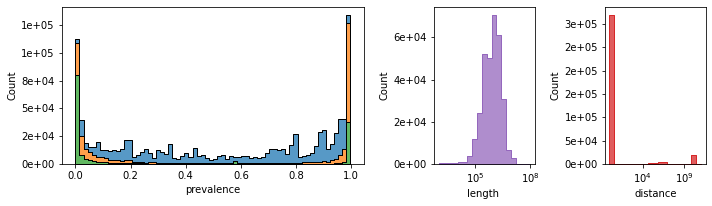

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(10,3),gridspec_kw={'width_ratios': [3, 1,1]})
for i, std_float in enumerate([.1]):
    std = str(std_float)
    print('\n\n', std)
    df = regions_ground_truth.copy()
    df = df [['hap_name', 'chrom_true', 'start_true', 'end_true', 'prevalence', 'chrom_pred_%s' % std, 'start_pred_%s' % std, 'end_pred_%s' % std]]
    df.columns = ['hap_name', 'chrom_true', 'start_true', 'end_true', 'prevalence', 'chrom_pred', 'start_pred', 'end_pred']
    
    unlocalized = df[np.isnan(df['chrom_pred'])].copy()
    unlocalized['status'] = 'unlocalized'
    localized = df[~np.isnan(df['chrom_pred'])].copy()

    correct = localized[(localized.chrom_true==localized['chrom_pred']) & 
          (localized['end_pred']>=localized.start_true) & (localized['start_pred']<=localized.end_true)].copy()
    correct['status'] = 'correct'
    incorrect = localized[~((localized.chrom_true==localized['chrom_pred']) & 
                          (localized['end_pred']>=localized.start_true) & 
                          (localized['start_pred']<=localized.end_true))].copy()
    incorrect['status'] = 'incorrect'

    new_df = pd.concat([correct, incorrect, unlocalized])
    new_df['length'] = new_df['end_pred']-new_df['start_pred']
    g = sns.histplot(new_df, x='prevalence', hue='status',  element='step', multiple='stack', hue_order=['correct', 'incorrect', 'unlocalized'], ax=ax[0], legend=False)
    #ax[0].set_ylim(0,50000)
    ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

    # Compute some metrics on subsection of dataframe.
    new_df = new_df[(new_df.prevalence>.2) & (new_df.prevalence<.8)]
    
    # Histograms of lengths for sensitivity
    sns.histplot(data=new_df[new_df.status=='correct'], x='length', element='step', bins=np.linspace(3,8,20), log_scale=True, ax=ax[1], color=sns.color_palette()[4], legend=False)
    #ax[1].set_ylim(0,150000)
    ax[1].set_xlabel('length ')
    ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

    
    # Distance from true value for incorrect
    right_chrom_wrong_loci = new_df[(~np.isnan(new_df.chrom_pred)) & (new_df.chrom_true==new_df['chrom_pred'])]
    new_df['distance'] = [2e10 if chrom_pred!=chrom_true else max(d1, d2,1) for d1, d2, chrom_pred, chrom_true in zip(new_df['start_true']-new_df['end_pred'], 
                                                      new_df['start_pred']-new_df['end_true'], new_df['chrom_pred'], new_df['chrom_true'])]
    sns.histplot(data=new_df[new_df.status!='unlocalized'], x='distance', element='step', bins=np.linspace(0,11,20), log_scale=True, color=sns.color_palette()[3], ax=ax[2], legend=False)
    #ax[2].set_ylim(0,30000)
    ax[2].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    
    
    #for a in [0,1,2]:
    #    ax[a].spines["right"].set_visible(False)
    ##    ax[a].spines["top"].set_visible(False)
     #   if a>0: ax[a].set_ylabel('')
    
    #if i!=3:
    #    for a in [0,1,2]:
    ##        ax[a].set_ylabel('')
    #        ax[a].set_xlabel('')
    #        ax[a].spines["bottom"].set_visible(False)
    #        ax[a].spines["left"].set_visible(False)
    #        ax[a].set_xticks([])
    #        ax[a].set_yticks([])
    
            

        
        
  

    print('unlocalized: ', np.mean(new_df.status=='unlocalized'))
    print('localized: ', np.mean(new_df.status!='unlocalized'))

    print('correct: ', np.mean(new_df.status=='correct'))
    print('correct_chrom out of inccorect: ', (np.sum((new_df.status=='incorrect') & (new_df.chrom_pred==new_df.chrom_true)))/np.sum(new_df.status=='incorrect'))
    print('median distance from true:', np.median(new_df[(new_df.chrom_pred==new_df.chrom_true) & (new_df.status=='incorrect')]['distance']))
    print('incorrect: ', np.mean(new_df.status=='incorrect'))
    print('accuracy: ', np.sum(new_df.status=='correct')/np.sum(new_df.status!='unlocalized'))
    print('med length:', np.median(new_df[new_df.status=='correct']['end_pred']-new_df[new_df.status=='correct']['start_pred']))
plt.tight_layout()

plt.show()

In [45]:
sns.histplot(data=new_df[new_df.status!='unlocalized'], x='distance', element='step', bins=np.linspace(3,8,20), log_scale=True, color=sns.color_palette()[3], ax=ax[2], legend=False)


<AxesSubplot:xlabel='distance', ylabel='Count'>

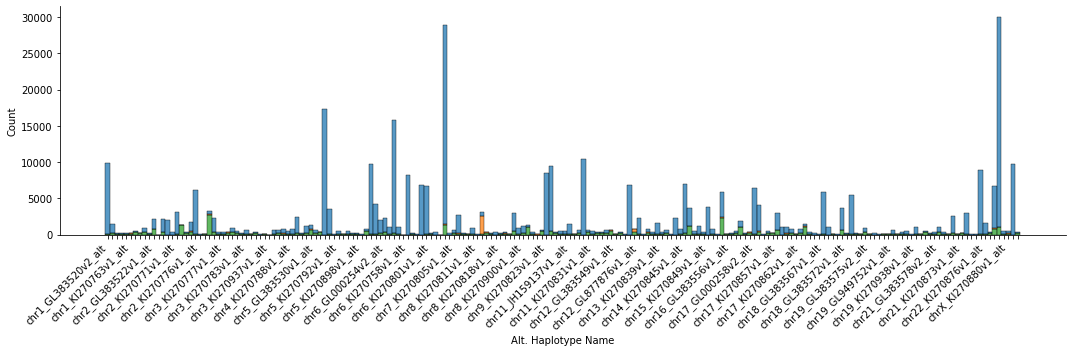

In [86]:
f, ax = plt.subplots(figsize=(15,5))
g = sns.histplot(data=new_df.sort_values(['chrom_true', 'hap_name', 'status']), x='hap_name', hue='status', multiple='stack', hue_order=['correct', 'incorrect', 'unlocalized'], legend=False)
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)
plt.xlabel('Alt. Haplotype Name')
plt.xticks(rotation=45, ha='right')
#plt.yscale('symlog', linthresh=10000)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/known_alt_haps_hap_names.svg', transparent=True)
plt.show()


In [126]:
new_df.groupby('hap_name')['status'].aggregate(lambda x: sum(np.array(x)=='incorrect')).sort_values(ascending=False).iloc[:10]

hap_name
chr8_KI270813v1_alt     2400
chr12_GL877875v1_alt     446
chr2_KI270894v1_alt       91
chr17_KI270907v1_alt      65
chr22_KI270878v1_alt      57
chr15_KI270905v1_alt      57
chr8_KI270901v1_alt       46
chr2_KI270772v1_alt       46
chr7_KI270803v1_alt       37
chr22_KI270879v1_alt      35
Name: status, dtype: int64

In [134]:
Counter(new_df[(new_df.status=='incorrect') & (new_df.chrom_pred==8.0)].hap_name)

Counter({'chr1_KI270762v1_alt': 1,
         'chr1_KI270764v1_alt': 1,
         'chr1_KI270763v1_alt': 4,
         'chr2_KI270774v1_alt': 1,
         'chr2_GL383522v1_alt': 1,
         'chr3_KI270779v1_alt': 1,
         'chr4_KI270785v1_alt': 3,
         'chr7_KI270808v1_alt': 1,
         'chr8_KI270821v1_alt': 1,
         'chr8_KI270813v1_alt': 2399,
         'chr10_GL383545v1_alt': 1,
         'chr11_KI270831v1_alt': 1,
         'chr12_GL877875v1_alt': 1,
         'chr13_KI270841v1_alt': 3,
         'chr16_KI270853v1_alt': 3,
         'chr16_GL383557v1_alt': 2,
         'chr17_GL383563v3_alt': 1,
         'chr17_KI270857v1_alt': 6,
         'chr18_GL383571v1_alt': 1,
         'chr20_KI270869v1_alt': 1,
         'chr22_KI270878v1_alt': 3,
         'chr22_KI270879v1_alt': 10,
         'chr2_KI270894v1_alt': 7,
         'chr8_KI270901v1_alt': 2,
         'chr8_KI270900v1_alt': 3,
         'chr12_KI270904v1_alt': 4,
         'chr15_KI270905v1_alt': 2,
         'chr17_KI270907v1_alt': 1,
 

In [130]:
Counter(new_df[(new_df.hap_name=='chr15_KI270905v1_alt') & (new_df.status=='incorrect')].chrom_pred)# 4997115.0-  137674-3884918.0

Counter({10.0: 2,
         2.0: 15,
         14.0: 7,
         11.0: 4,
         13.0: 2,
         8.0: 2,
         1.0: 1,
         4.0: 2,
         17.0: 2,
         6.0: 1,
         9.0: 2,
         15.0: 1,
         22.0: 1,
         21.0: 1,
         5.0: 2,
         12.0: 1})

In [104]:
new_df.groupby('hap_name')['status'].aggregate(lambda x: sum(np.array(x)=='incorrect')/sum(np.array(x)!='unlocalized')).sort_values(ascending=False)[:30]

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in long_scalars
  """Entry point for launching an IPython kernel.


hap_name
chr5_KI270793v1_alt     1.000000
chr12_GL877875v1_alt    1.000000
chr3_KI270784v1_alt     1.000000
chr9_GL383541v1_alt     1.000000
chr1_KI270765v1_alt     1.000000
chr19_GL383575v2_alt    1.000000
chr7_KI270899v1_alt     1.000000
chr8_KI270820v1_alt     1.000000
chr2_KI270772v1_alt     0.978723
chr1_KI270763v1_alt     0.846154
chr8_KI270813v1_alt     0.785855
chr21_KI270872v1_alt    0.500000
chr21_KI270873v1_alt    0.358974
chr3_KI270779v1_alt     0.354430
chr1_KI270762v1_alt     0.307692
chr15_KI270906v1_alt    0.285714
chr11_KI270927v1_alt    0.223022
chr17_KI270907v1_alt    0.181058
chr2_KI270894v1_alt     0.174330
chr8_KI270815v1_alt     0.166667
chr16_KI270856v1_alt    0.153846
chr8_KI270901v1_alt     0.120104
chr20_KI270870v1_alt    0.116667
chr20_KI270869v1_alt    0.105263
chr3_KI270782v1_alt     0.086957
chr5_GL383531v1_alt     0.083333
chr9_GL383542v1_alt     0.081522
chr1_KI270764v1_alt     0.069444
chr11_KI270830v1_alt    0.064024
chr11_KI270902v1_alt    0.061224
N

In [18]:
sizes_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38_chromsome_sizes.txt', header=None)
sizes = [int(s.replace(',','')) for s in sizes_df[2]]
starts = [np.sum(sizes[:i]) for i in range(23)] + [3041559849]

def loci_linear_idx(chrom, loci):
    chrom=int(chrom)
    if chrom==24: chrom=23
    return starts[chrom-1]+loci
linear_idxs = [loci_linear_idx(chrom, loci) for chrom, loci in zip(new_df[new_df.status!='unlocalized'].chrom_pred, new_df[new_df.status!='unlocalized'].start_pred)]

In [82]:
f, ax = plt.subplots(figsize=(15,.5))
for i in range(23):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom==23: chrom='X'
    plt.text(x=np.mean(starts[i:i+2]), y=.4, s=chrom, fontsize=9, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts[i], xmax=starts[i+1], y=.6, color=color, linestyle='-', linewidth=7)
plt.xlim(0,starts[-1]+1e8)
ax.axis('off')
plt.ylim(.4,.6)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/chromsome_labels.svg', transparent=True)
plt.show()

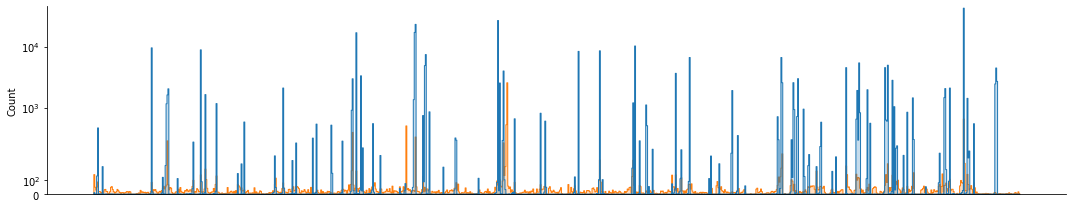

In [78]:
f, ax = plt.subplots(figsize=(15,3))
sns.histplot(x=linear_idxs, hue=new_df[new_df.status!='unlocalized'].status, bins=1000,element='step', kde_kws=dict(linewidth=0), legend=False)#hist_kws=dict(edgecolor="k", linewidth=0)) #bins=1000)
ax.set_xticks([])
plt.yscale('symlog', linthresh=500)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/known_alt_haps_locations.svg', transparent=True)
plt.show()


In [ ]:
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)

# Unlocalized Decoy Sequence


In [68]:
regions_unlocalized_decoy = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/approximate_regions/localized_ground_truth.tsv',
                                   names = ['chrom_true', 'loci_true', 'median_of_nonzeros', 'prevalence',
                                            'chrom_pred_10', 'start_pred_10', 'end_pred_10', 
                                            'chrom_pred_25', 'start_pred_25', 'end_pred_25',
                                            'chrom_pred_50', 'start_pred_50', 'end_pred_50'], delimiter='\t', comment='#')

kmers_unlocalized_decoy = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/data/known_kmers.txt',  delimiter='\t', nrows=len(regions_ground_truth), header=None, names=['name'], usecols=[1])

regions_unlocalized_decoy['hap_name'] = kmers_ground_truth.name

for std in ['10', '25', '50']:
    print('\n\n', std)
    df = regions_ground_truth.copy()
    df = df[(df.prevalence>.1) & (df.prevalence<.8)]
    unlocalized = df[np.isnan(df['chrom_pred_%s' % std])].copy()
    unlocalized['status'] = 'unlocalized'
    localized = df[~np.isnan(df['chrom_pred_%s' % std])].copy()

    correct = localized[(localized.chrom_true==localized['chrom_pred_%s' % std])].copy()
    correct['status'] = 'correct'
    incorrect = localized[(localized.chrom_true!=localized['chrom_pred_%s' % std])].copy()
    incorrect['status'] = 'incorrect'

    new_df = pd.concat([correct, incorrect, unlocalized])
    print('unlocalized: ', np.mean(new_df.status=='unlocalized'))
    print('correct: ', np.mean(new_df.status=='correct'))
    print('incorrect: ', np.mean(new_df.status=='incorrect'))
    print('accuracy: ', np.mean(new_df.status=='correct')/np.mean(new_df.status!='unlocalized'))
    print('med length:', np.median(correct['end_pred_%s' % std]-correct['start_pred_%s' % std]))





 10
unlocalized:  0.030492542446281412
correct:  0.8987424267512408
incorrect:  0.07076503080247779
accuracy:  0.9270092970908821
med length: 636828.0


 25
unlocalized:  0.06147333919238493
correct:  0.8929619204103034
incorrect:  0.04556474039731163
accuracy:  0.9514507767332869
med length: 1627598.0


 50
unlocalized:  0.09485507338674411
correct:  0.8844981382651264
incorrect:  0.020646788348129563
accuracy:  0.9771895220963313
med length: 2935094.0


<AxesSubplot:xlabel='prevalence', ylabel='Count'>

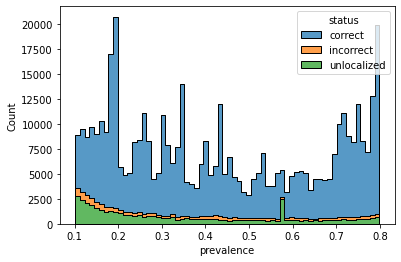

In [67]:
sns.histplot(new_df, x='prevalence', hue='status',  element='step', multiple='stack', hue_order=['correct', 'incorrect', 'unlocalized'])

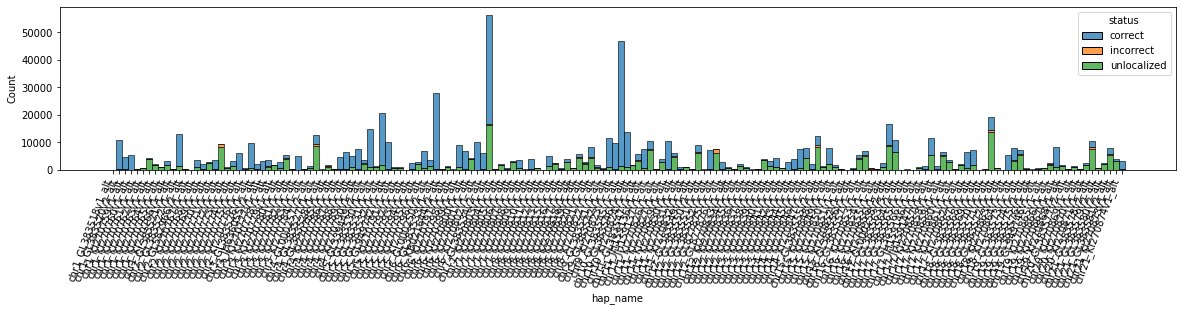

In [39]:
plt.figure(figsize=(20,3))
sns.histplot(data=new_df.sort_values(['chrom_true', 'hap_name', 'status']), x='hap_name', hue='status', multiple='stack', hue_order=['correct', 'incorrect', 'unlocalized'])
plt.xticks(rotation=70, ha='right')
plt.show()


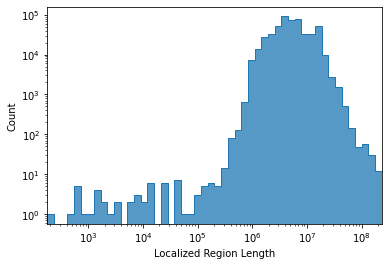

In [41]:
correct['length_pred'] = correct['end_pred']-correct['start_pred']
correct['chrom'] = [str(int(s)) for s in correct.chrom_pred]
sns.histplot(data=correct[::-1], x='length_pred', log_scale=True, bins=50, element='step')
plt.xlim(min(correct.length_pred),max(correct.length_pred))
plt.yscale('log')
plt.xlabel('Localized Region Length')
plt.show()

In [42]:
np.median(correct.length_pred)

5048745.0

In [ ]:
correct['length_pred'] = correct['end_pred']-correct['start_pred']
correct['chrom'] = [str(int(s)) for s in correct.chrom_pred]
sns.histplot(data=correct[::-1], x='length_pred', log_scale=True, bins=50, element='step', hue='chrom', multiple='stack')
plt.xlim(min(correct.length_pred)/2,)
plt.xlabel('Localized Region Length')
plt.show()